In [1]:
import pip

package_names = ['awswrangler', 'swifter'] 
pip.main(['install'] + package_names + ['--upgrade'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [2]:
# Nativos
from dateutil.relativedelta import relativedelta
from time import gmtime, strftime
from datetime import datetime
import random as rn
import joblib
import json
import sys
import os
import gc

#nube
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker import get_execution_role
import awswrangler as wr
import sagemaker
import boto3

#calculo
import pandas as pd
import numpy as np
import scipy

#grafico
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()
# MODELS
#from lightgbm import LGBMClassifier

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)
#import scorecardpy as sc
#from utils import *
#from graphs import *

SEED = 29082013
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

#from utils import *
#from modeler import *
#subfolder = "data"
# os.listdir(subfolder)

from setup import *

////////////////////////////////////////////////// 

path_container_input:  /opt/ml/processing/input
path_container_output:  /opt/ml/processing/output
path_container_utils:  /opt/ml/processing/input/utils
path_container_universo:  /opt/ml/processing/input/HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE
target :::::::::  target_desembolso_f2m_mayor_30_menor_180


## >> Load last rcc month

In [3]:
query = """
    SELECT {}
    FROM d_mdl_vpc_disc.HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE
    WHERE PERIODO = (SELECT MAX(PERIODO) from d_mdl_vpc_disc.HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE)
""".format(
    ', '.join(cols_pre_export)
)

print(query)


    SELECT periodo, cod_sbs_val, target_desembolso_f2m_mayor_30_menor_180, sow_ibk, porc_coloc_direct_vig_cmpt, porc_coloc_direct_vig_cajas, porc_coloc_direct_vig_no_ibk, porc_coloc_direct_vig_bcos, sow_otros_bancos, porc_coloc_direct_vig_ibk, sow_cajas, saldo_coloc_direct_vig_cmpt, ult_var_saldo_ajustado_amt, saldo_coloc_direct_vig_no_ibk, saldo_coloc_direct_vig_cajas, saldo_reactiva, saldo_coloc_indirectas, var_neta_saldo_ajustado_u3_amt, saldo_fae, saldo_coloc_directas, saldo_coloc_direct_vig_bcos, saldo_coloc_direct_vig_ibk, saldo_coloc_direct_tc, deuda_sf_prom_ult9m, prom_reprog_u12m, nro_entid_financ_prom_ult9m_cnt, monto_adquirido_u6_amt, nro_var_10k_30k_negativa_u6, prom_gar_u12m, nroregs_reactiva_bcos, monto_pagado_u3_amt, nro_entidades, monto_pagado_ult_rcc_amt, tendencia_nro_coloc_direct_bancos_v2, prom_fae_u12m, nro_var_10k_30k_negativa_u3, nroregs_fae_bcos
    FROM d_mdl_vpc_disc.HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE
    WHERE PERIODO = (SELECT MAX(PERIODO) from d_mdl_vpc

In [4]:
df = wr.athena.read_sql_query(query, database="e_perm_aws",ctas_approach=False)
print(df.shape)

df.head()

(725032, 37)


,periodo,cod_sbs_val,target_desembolso_f2m_mayor_30_menor_180,sow_ibk,porc_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cajas,porc_coloc_direct_vig_no_ibk,porc_coloc_direct_vig_bcos,sow_otros_bancos,porc_coloc_direct_vig_ibk,sow_cajas,saldo_coloc_direct_vig_cmpt,ult_var_saldo_ajustado_amt,saldo_coloc_direct_vig_no_ibk,saldo_coloc_direct_vig_cajas,saldo_reactiva,saldo_coloc_indirectas,var_neta_saldo_ajustado_u3_amt,saldo_fae,saldo_coloc_directas,saldo_coloc_direct_vig_bcos,saldo_coloc_direct_vig_ibk,saldo_coloc_direct_tc,deuda_sf_prom_ult9m,prom_reprog_u12m,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,nro_var_10k_30k_negativa_u6,prom_gar_u12m,nroregs_reactiva_bcos,monto_pagado_u3_amt,nro_entidades,monto_pagado_ult_rcc_amt,tendencia_nro_coloc_direct_bancos_v2,prom_fae_u12m,nro_var_10k_30k_negativa_u3,nroregs_fae_bcos
0,202108,0135142913,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,-1158.300,0.000,1182.750,0.000,0.000,-3407.250,17015.040,1182.750,0.000,0.000,0.000,27026.13,3544.860000,1,0.000,0,30066.666667,0,3407.250,1,1158.300,0.0,19803.734167,0,0
1,202108,0120836005,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,90155.960,6121.290,0.000,-1653.990,0.000,90155.960,0.000,0.000,0.000,87424.75,27930.186667,1,32656.960,1,0.000000,0,2043.820,1,0.000,0.0,0.000000,0,0
2,202108,0117933857,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,-438.540,46276.540,0.000,0.000,0.000,-1351.980,0.000,46276.540,46276.540,0.000,0.000,47755.83,47284.645000,1,0.000,0,47285.645000,0,1351.980,1,438.540,1.0,0.000000,0,0
3,202108,0035357246,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1135.430,0.000,0.000,0.000,0.000,-3393.680,0.000,78912.240,0.000,0.000,0.000,83307.79,36221.618333,1,0.000,0,0.000000,0,3393.680,1,1135.430,1.0,0.000000,0,0
4,202108,0199482734,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,-201.730,0.000,0.000,0.000,0.000,-606.530,0.000,893.520,893.520,893.520,0.000,557.34,0.000000,0,1500.050,0,0.000000,0,606.530,1,201.730,4.0,0.000000,0,0


### CORRECION DE TIPADO

In [5]:
import swifter

def convert_num(val):
    try:
        return float(val)
    except:
        print('|', val, '|')
        return 0.0

df[target] = df[target].swifter.apply(convert_num)

NumExpr defaulting to 4 threads.


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

In [6]:
cols_id = ['periodo_val', 'cod_sbs_val']

In [7]:
cols_num = [col for col in df.describe().T.index if col not in cols_id]
print(len(cols_num))

11


In [8]:
cols_str = [col for col in list(df.select_dtypes(include=[object, bool]).columns) if col not in cols_id]
print(len(cols_str))

24


In [9]:
col_convert_num = [
    col for col in cols_str if not('_val' in col.lower() or '_cd' in col.lower())
]

print(col_convert_num)

['sow_ibk', 'porc_coloc_direct_vig_cmpt', 'porc_coloc_direct_vig_cajas', 'porc_coloc_direct_vig_no_ibk', 'porc_coloc_direct_vig_bcos', 'sow_otros_bancos', 'porc_coloc_direct_vig_ibk', 'sow_cajas', 'saldo_coloc_direct_vig_cmpt', 'ult_var_saldo_ajustado_amt', 'saldo_coloc_direct_vig_no_ibk', 'saldo_coloc_direct_vig_cajas', 'saldo_reactiva', 'saldo_coloc_indirectas', 'var_neta_saldo_ajustado_u3_amt', 'saldo_fae', 'saldo_coloc_directas', 'saldo_coloc_direct_vig_bcos', 'saldo_coloc_direct_vig_ibk', 'saldo_coloc_direct_tc', 'deuda_sf_prom_ult9m', 'monto_adquirido_u6_amt', 'monto_pagado_u3_amt', 'monto_pagado_ult_rcc_amt']


In [10]:
for col in col_convert_num:
    print("/"*25, col)
    df[col] = df[col].swifter.apply(convert_num)

///////////////////////// sow_ibk


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// porc_coloc_direct_vig_cmpt


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// porc_coloc_direct_vig_cajas


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// porc_coloc_direct_vig_no_ibk


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// porc_coloc_direct_vig_bcos


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// sow_otros_bancos


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// porc_coloc_direct_vig_ibk


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// sow_cajas


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_direct_vig_cmpt


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// ult_var_saldo_ajustado_amt


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_direct_vig_no_ibk


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_direct_vig_cajas


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_reactiva


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_indirectas


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// var_neta_saldo_ajustado_u3_amt


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_fae


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_directas


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_direct_vig_bcos


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_direct_vig_ibk


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// saldo_coloc_direct_tc


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// deuda_sf_prom_ult9m


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// monto_adquirido_u6_amt


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// monto_pagado_u3_amt


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

///////////////////////// monto_pagado_ult_rcc_amt


Pandas Apply:   0%|          | 0/725032 [00:00<?, ?it/s]

In [11]:
cols_num = [col for col in df[seleccionadas].describe().T.index if col not in cols_id]
print(len(cols_num))

19


In [12]:
len(cols_num) == len(seleccionadas)

True

### COLUMNAS DE ANALISIS

In [13]:
from UTILITARIO_CODE.utils import generate_groups

print(df.shape)
df = generate_groups(df)
print(df.shape)

(725032, 37)
////////////////////////////////////////////////// porc_coloc_direct_vig_bcos
////////////////////////////////////////////////// porc_coloc_direct_vig_cmpt
////////////////////////////////////////////////// porc_coloc_direct_vig_no_ibk
////////////////////////////////////////////////// porc_coloc_direct_vig_ibk
////////////////////////////////////////////////// porc_coloc_direct_vig_cajas
////////////////////////////////////////////////// sow_ibk
////////////////////////////////////////////////// sow_otros_bancos
////////////////////////////////////////////////// sow_cajas
////////////////////////////////////////////////// nroregs_reactiva_bcos
////////////////////////////////////////////////// nroregs_fae_bcos
(725032, 56)


### PREDICCION

In [15]:
from sagemaker.estimator import Estimator, Transformer
from sagemaker.serializers import CSVSerializer
from sklearn.metrics import roc_auc_score

def predict_(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    
    for array in split_array:
        predictions = ','.join(
            [
                predictions, 
                model_predictor.predict(array).decode('utf-8')
            ]
        )

    return np.fromstring(predictions[1:], sep=',')

In [16]:
grupos_score = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'][::-1]
cortes_deciles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cortes_deciles_fino = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1]

In [17]:
model_code = 'xgboost-vpc-7-210927-1550-041-301a74a7'
model_code

'xgboost-vpc-7-210927-1550-041-301a74a7'

In [18]:
model = Estimator.attach(model_code)

model_predictor = model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.xlarge',
    serializer=CSVSerializer()
)    
print(model_predictor.content_type, model_predictor.endpoint_name)


2021-09-27 16:28:31 Starting - Preparing the instances for training
2021-09-27 16:28:31 Downloading - Downloading input data
2021-09-27 16:28:31 Training - Training image download completed. Training in progress.
2021-09-27 16:28:31 Uploading - Uploading generated training model
2021-09-27 16:28:31 Completed - Training job completed
Creating model with name: xgboost-vpc-7-2021-09-28-05-42-52-020
Creating endpoint with name xgboost-vpc-7-2021-09-28-05-42-52-020
-----!text/csv xgboost-vpc-7-2021-09-28-05-42-52-020


<AxesSubplot:>

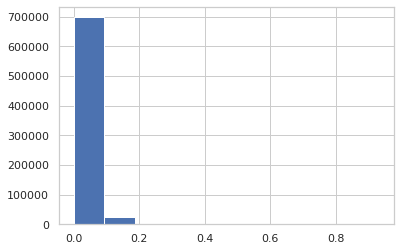

In [19]:
prediccion = predict_(df[seleccionadas].values)

pd.Series(prediccion).hist()

In [20]:
prediccion[prediccion >= 0.5].shape, prediccion.max()

((10,), 0.9295591711997986)

In [21]:
df['score_desembolso'] = prediccion
df['GRUPO_PROPENSION'] = list(pd.qcut(df['score_desembolso'], cortes_deciles, labels=grupos_score))

group_ = df.groupby(by=['GRUPO_PROPENSION']).agg({
    target: ['mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_.round(4)

target_desembolso_f2m_mayor_30_menor_180      score_desembolso
                                                     mean  sum             mean
GRUPO_PROPENSION                                                               
A                                                     0.0  0.0           0.0953
B                                                     0.0  0.0           0.0492
C                                                     0.0  0.0           0.0350
D                                                     0.0  0.0           0.0266
E                                                     0.0  0.0           0.0208
F                                                     0.0  0.0           0.0166
G                                                     0.0  0.0           0.0133
H                                                     0.0  0.0           0.0104
I                                                     0.0  0.0           0.0080
J                                                     0.0  0.0           0.0050

In [22]:
df['GRUPO_PROPENSION_FINO'] = list(pd.qcut(df['score_desembolso'], cortes_deciles_fino, labels=grupos_score))

group = df.groupby(by=['GRUPO_PROPENSION_FINO']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group.round(4)

target_desembolso_f2m_mayor_30_menor_180           score_desembolso
                                                         count mean  sum             mean
GRUPO_PROPENSION_FINO                                                                    
A                                                         7251  0.0  0.0           0.1881
B                                                        29001  0.0  0.0           0.1038
C                                                        36252  0.0  0.0           0.0699
D                                                        72503  0.0  0.0           0.0492
E                                                       145006  0.0  0.0           0.0308
F                                                       145006  0.0  0.0           0.0187
G                                                        72501  0.0  0.0           0.0133
H                                                        72504  0.0  0.0           0.0104
I                                                        72503  0.0  0.0           0.0080
J                                                        72505  0.0  0.0           0.0050

In [23]:
df.head()

,periodo,cod_sbs_val,target_desembolso_f2m_mayor_30_menor_180,sow_ibk,porc_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cajas,porc_coloc_direct_vig_no_ibk,porc_coloc_direct_vig_bcos,sow_otros_bancos,porc_coloc_direct_vig_ibk,sow_cajas,saldo_coloc_direct_vig_cmpt,ult_var_saldo_ajustado_amt,saldo_coloc_direct_vig_no_ibk,saldo_coloc_direct_vig_cajas,saldo_reactiva,saldo_coloc_indirectas,var_neta_saldo_ajustado_u3_amt,saldo_fae,saldo_coloc_directas,saldo_coloc_direct_vig_bcos,saldo_coloc_direct_vig_ibk,saldo_coloc_direct_tc,deuda_sf_prom_ult9m,prom_reprog_u12m,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,nro_var_10k_30k_negativa_u6,prom_gar_u12m,nroregs_reactiva_bcos,monto_pagado_u3_amt,nro_entidades,monto_pagado_ult_rcc_amt,tendencia_nro_coloc_direct_bancos_v2,prom_fae_u12m,nro_var_10k_30k_negativa_u3,nroregs_fae_bcos,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,_categoryc_nroregs_reactiva_bcos,_categoryc_nroregs_fae_bcos,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO
0,202108,0135142913,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1158.30,0.00,1182.75,0.00,0.0,-3407.25,17015.04,1182.75,0.00,0.00,0.0,27026.13,3544.860000,1,0.00,0,30066.666667,0,3407.25,1,1158.30,0.0,19803.734167,0,0,1. <0-10k],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],2. <10k:30k],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0,0,0.015564,F,F
1,202108,0120836005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.00,90155.96,6121.29,0.0,-1653.99,0.00,90155.96,0.00,0.00,0.0,87424.75,27930.186667,1,32656.96,1,0.000000,0,2043.82,1,0.00,0.0,0.000000,0,0,<3. 30k:120k],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],<3. 30k:120k],1. <0-10k],0. <:0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0,0,0.030384,C,E
2,202108,0117933857,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-438.54,46276.54,0.00,0.00,0.0,-1351.98,0.00,46276.54,46276.54,0.00,0.0,47755.83,47284.645000,1,0.00,0,47285.645000,0,1351.98,1,438.54,1.0,0.000000,0,0,<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],0. <:0],0. <:0],0. <:0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0,0,0.008850,I,I
3,202108,0035357246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1135.43,0.00,0.00,0.00,0.0,-3393.68,0.00,78912.24,0.00,0.00,0.0,83307.79,36221.618333,1,0.00,0,0.000000,0,3393.68,1,1135.43,1.0,0.000000,0,0,<3. 30k:120k],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0,0,0.018765,E,F
4,202108,0199482734,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-201.73,0.00,0.00,0.00,0.0,-606.53,0.00,893.52,893.52,893.52,0.0,557.34,0.000000,0,1500.05,0,0.000000,0,606.53,1,201.73,4.0,0.000000,0,0,1. <0-10k],0. <:0],1. <0-10k],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0. <:0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0,0,0.005838,J,J


In [ ]:
uri_output

In [ ]:
df.to_csv("{}/MM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE.csv".format(uri_output), index=False)